# Import and Split

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import All Model Types
from sklearn import metrics, preprocessing, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


# Pull Dataset
from google.colab import drive
drive.mount('/content/drive')
patientsData = pd.read_csv('drive/My Drive/patients.csv')

Mounted at /content/drive


Split data into training and testing

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(patientsData, patientsData["Outcome"]):
  strat_train_set = patientsData.iloc[train_index]
  strat_test_set = patientsData.iloc[test_index]

# Preprocessing

Split training and testing data into the independent and dependent variables

In [ ]:
train = strat_train_set.drop("Outcome", axis=1)
train_labels = strat_train_set["Outcome"].copy()

test = strat_test_set.drop("Outcome", axis=1)
test_labels = strat_test_set["Outcome"].copy()

In [ ]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 222 to 507
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               600 non-null    int64  
 1   Glucose                   600 non-null    int64  
 2   BloodPressure             600 non-null    int64  
 3   SkinThickness             600 non-null    int64  
 4   Insulin                   600 non-null    int64  
 5   BMI                       600 non-null    float64
 6   DiabetesPedigreeFunction  600 non-null    float64
 7   Age                       600 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 42.2 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
222,0,117,80,31,53,45.2,0.089,24
523,0,105,90,0,0,29.6,0.197,46
626,6,147,80,0,0,29.5,0.178,50
130,2,96,68,13,49,21.1,0.647,26
719,8,65,72,23,0,32.0,0.600,42


In [ ]:
num_attribs = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"]
num_maxmin_attribs = ["Age"]
cat_attribs = ["Pregnancies"]

Replace all instances of missing data with the mean for that data

In [ ]:
trainFixMissing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for i in trainFixMissing:
    train[i] = pd.to_numeric(train[i], errors='coerce')
    train[i].replace(0, float('nan'), inplace=True)

    trainMean = train[i].mean()

    train[i].fillna(trainMean, inplace=True)

testFixMissing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for i in testFixMissing:
    test[i] = pd.to_numeric(test[i], errors='coerce')
    test[i].replace(0, float('nan'), inplace=True)

    testMean = test[i].mean()

    test[i].fillna(testMean, inplace=True)

Create Data Pipeline

In [ ]:
my_imputer = SimpleImputer(strategy='median')

numeric_minmax_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                    ('minmaxscaler', MinMaxScaler())])

cat_pipeline = Pipeline([('onehot', OneHotEncoder())])

In [ ]:
from sklearn.compose import ColumnTransformer

full_transformer = ColumnTransformer([('numeric_minmaxpreprocessing', numeric_minmax_pipeline, num_maxmin_attribs),
                                 ('cat_preprocessing', cat_pipeline, cat_attribs)
                                ])

Evaluation Function

In [ ]:
def evaluate_performance(true_labels, predictions):
    conf_matrix = confusion_matrix(true_labels, predictions)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]

    print('TP:', TP)
    print('FP:', FP)
    print('TN:', TN)
    print('FN:', FN)

    accuracy = accuracy_score(true_labels, predictions)
    print("Accuracy:", accuracy)

    precision = precision_score(true_labels, predictions)
    print("Precision:", precision)

    recall = recall_score(true_labels, predictions)
    print("Recall:", recall)

    specificity = TN / (TN + FP)
    print("Specificity:", specificity)

    f1 = f1_score(true_labels, predictions)
    print("F1-Score:", f1)

ROC Curve Function

In [ ]:
def rocCurve(test,test_labels, model):
  y_pred_prob_lr = model.predict_proba(test)[:, 1]
  fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob_lr)
  roc_auc = roc_auc_score(test_labels, y_pred_prob_lr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

# Logistics

In [ ]:
logisticsPipeline = Pipeline([
    ('all_column_transformation', full_transformer),
    ('logisticregressuion', LogisticRegression())
])

TP: 12
FP: 15
TN: 85
FN: 38
Accuracy: 0.6466666666666666
Precision: 0.4444444444444444
Recall: 0.24
Specificity: 0.85
F1-Score: 0.3116883116883117


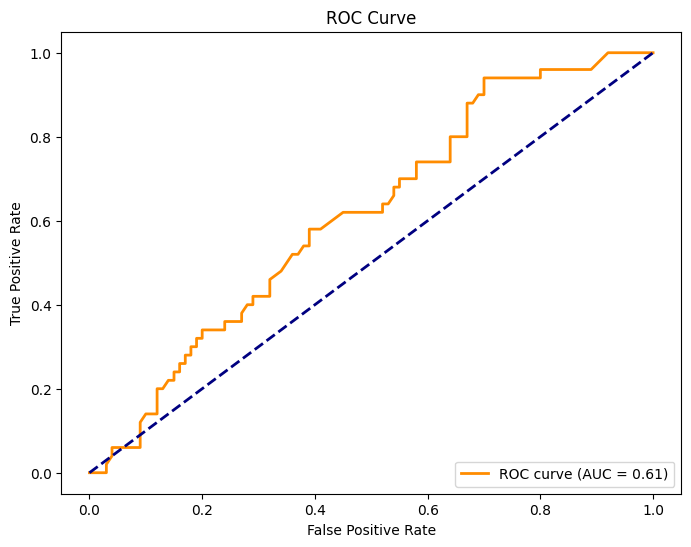

In [ ]:
logisticsPipeline.fit(train, train_labels)
logistics_predicted_values = logisticsPipeline.predict(test)
evaluate_performance(test_labels, logistics_predicted_values)

rocCurve(test, test_labels, logisticsPipeline)

# AdaBoost

In [ ]:
adaBoostPipeline = Pipeline([
    ('all_column_transformation', full_transformer),
    ('adaboostclassifier', AdaBoostClassifier())
])

TP: 13
FP: 20
TN: 80
FN: 37
Accuracy: 0.62
Precision: 0.3939393939393939
Recall: 0.26
Specificity: 0.8
F1-Score: 0.3132530120481928


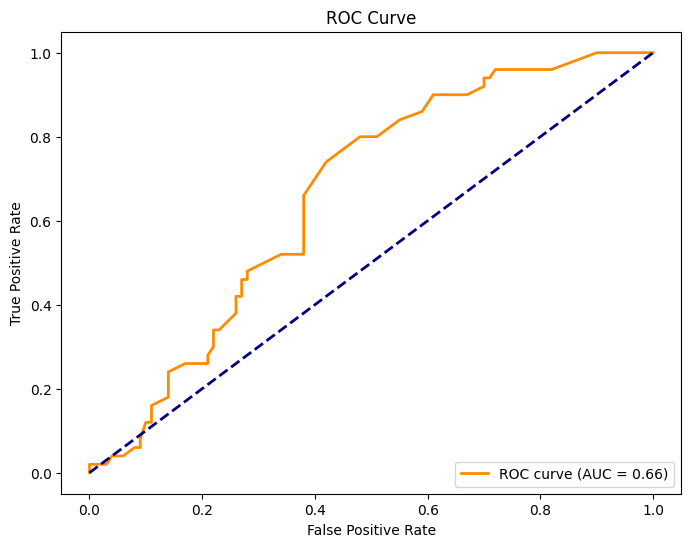

In [ ]:
adaBoostPipeline.fit(train, train_labels)
adaBoost_predicted_values = adaBoostPipeline.predict(test)
evaluate_performance(test_labels, adaBoost_predicted_values)

rocCurve(test, test_labels, adaBoostPipeline)

# AdaBoost with Grid Search



In [ ]:
adaBoostPipeline = Pipeline([
    ('all_column_transformation', full_transformer),
    ('adaboostclassifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))  # Using DecisionTreeClassifier as the base estimator
])

In [ ]:
param_grid = {
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=25)],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0]
}

In [ ]:
adaboost = AdaBoostClassifier()
grid_search = GridSearchCV(adaboost, param_grid, scoring='accuracy', cv=5)
grid_search.fit(train, train_labels)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

TP: 19
FP: 14
TN: 86
FN: 31
Accuracy: 0.7
Precision: 0.5757575757575758
Recall: 0.38
Specificity: 0.86
F1-Score: 0.45783132530120485


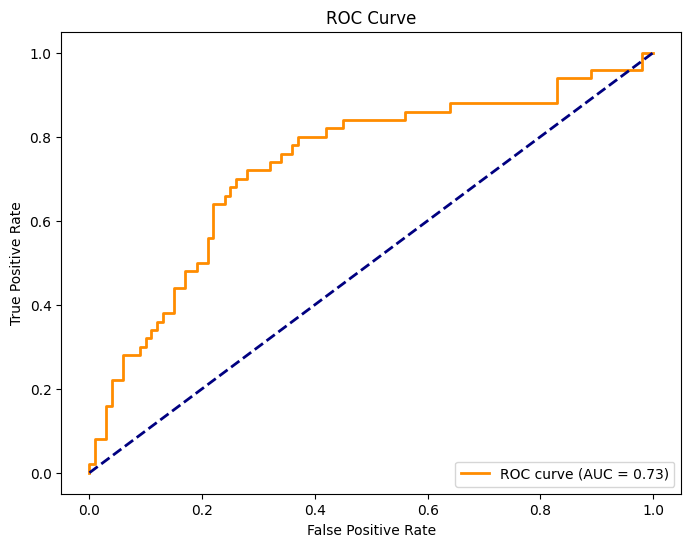

In [ ]:
predicted_values_best_model = best_model.predict(test)
evaluate_performance(test_labels, predicted_values_best_model)

rocCurve(test, test_labels, best_model)

# Tree Decision

In [ ]:
DecisionTreeClassificerPipeline = Pipeline([
    ('all_column_transformation', full_transformer),
    ('decisionTreeClassifier', DecisionTreeClassifier())
])

TP: 12
FP: 15
TN: 85
FN: 38
Accuracy: 0.6466666666666666
Precision: 0.4444444444444444
Recall: 0.24
Specificity: 0.85
F1-Score: 0.3116883116883117


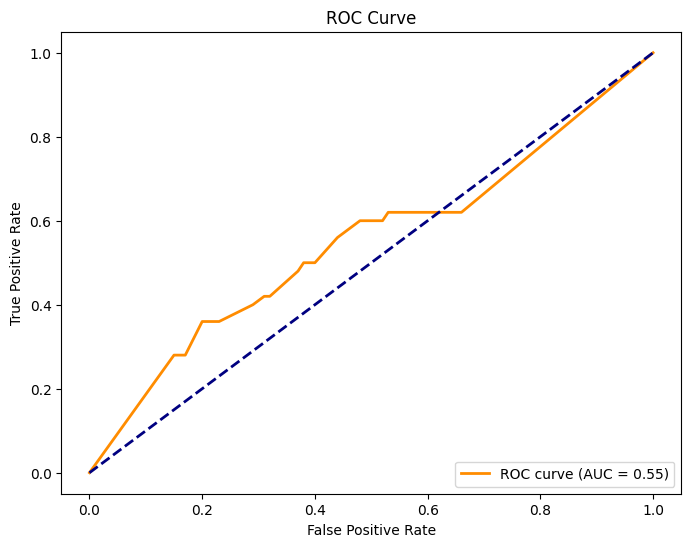

In [ ]:
DecisionTreeClassificerPipeline.fit(train, train_labels)
DecisionTree_predicted_values = DecisionTreeClassificerPipeline.predict(test)
evaluate_performance(test_labels, logistics_predicted_values)

rocCurve(test, test_labels, DecisionTreeClassificerPipeline)